In [1]:
# The `medicai` is medical-based 2D and 3D ML library. 
# We'll use it for segmentaiton model, 3D volume transformation, etc.
!pip install git+https://github.com/innat/medic-ai.git -q

# Installing this is optional, we will be using TFRecord format.
!pip install imagecodecs tifffile -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 74.5 MB/s eta 0:00:00


In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os, warnings
os.environ["KERAS_BACKEND"] = "torch"
warnings.filterwarnings('ignore')

In [3]:
import keras
from keras import ops

import torch
import tensorflow as tf

keras.version(), torch.__version__, keras.config.backend()

2025-12-07 01:24:52.820065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765070693.009878      21 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765070693.062694      21 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

('3.8.0', '2.6.0+cu124', 'torch')

## Data Loader

In [4]:
from medicai.transforms import (
    Compose,
    ScaleIntensityRange,
    Resize,
    RandShiftIntensity,
    RandRotate90,
    RandFlip,
    RandSpatialCrop
)

In [5]:
import tensorflow as tf
import numpy as np
from medicai.transforms import (
    Compose,
    ScaleIntensityRange,
    RandShiftIntensity,
    RandRotate90,
    RandFlip,
    RandSpatialCrop
)

# ==================== FIXED CUSTOM TRANSFORMS ====================

class RandAdjustContrast:
    """Random Contrast Adjustment (Gamma Correction) - TF Graph Compatible"""
    def __init__(self, keys, prob=0.3, gamma_range=(0.7, 1.3)):
        self.keys = keys
        self.prob = prob
        self.gamma_range = gamma_range
    
    def __call__(self, data):
        for key in self.keys:
            # Use tf.cond instead of Python if
            data[key] = tf.cond(
                tf.random.uniform([]) < self.prob,
                lambda: self._apply_gamma(data[key]),
                lambda: data[key]
            )
        return data
    
    def _apply_gamma(self, image):
        gamma = tf.random.uniform(
            [], 
            self.gamma_range[0], 
            self.gamma_range[1]
        )
        # Clip to [0, 1] before applying gamma
        image_clipped = tf.clip_by_value(image, 0.0, 1.0)
        return tf.pow(image_clipped, gamma)


class RandUnsharpMask:
    """Random Unsharp Masking - TF Graph Compatible"""
    def __init__(self, keys, prob=0.3, amount_range=(0.5, 1.5), kernel_size=3):
        self.keys = keys
        self.prob = prob
        self.amount_range = amount_range
        self.kernel_size = kernel_size
    
    def __call__(self, data):
        for key in self.keys:
            data[key] = tf.cond(
                tf.random.uniform([]) < self.prob,
                lambda: self._apply_unsharp_mask(data[key]),
                lambda: data[key]
            )
        return data
    
    def _apply_unsharp_mask(self, image):
        amount = tf.random.uniform(
            [], 
            self.amount_range[0], 
            self.amount_range[1]
        )
        
        # Simple box blur untuk 3D
        blurred = self._box_blur_3d(image, self.kernel_size)
        
        # Unsharp mask formula
        sharpened = image + amount * (image - blurred)
        return tf.clip_by_value(sharpened, 0.0, 1.0)
    
    def _box_blur_3d(self, volume, kernel_size):
        """Box blur menggunakan average pooling 3D"""
        # Add batch dimension
        volume_batched = volume[tf.newaxis, ...]
        
        # Apply 3D average pooling
        ksize = [1, kernel_size, kernel_size, kernel_size, 1]
        strides = [1, 1, 1, 1, 1]
        blurred = tf.nn.avg_pool3d(
            volume_batched,
            ksize=ksize,
            strides=strides,
            padding='SAME'
        )
        
        # Remove batch dimension
        return blurred[0]


class RandAddGaussianNoise:
    """Random Gaussian Noise - TF Graph Compatible"""
    def __init__(self, keys, prob=0.2, noise_std_range=(0.0, 0.05)):
        self.keys = keys
        self.prob = prob
        self.noise_std_range = noise_std_range
    
    def __call__(self, data):
        for key in self.keys:
            data[key] = tf.cond(
                tf.random.uniform([]) < self.prob,
                lambda: self._add_noise(data[key]),
                lambda: data[key]
            )
        return data
    
    def _add_noise(self, image):
        noise_std = tf.random.uniform(
            [], 
            self.noise_std_range[0], 
            self.noise_std_range[1]
        )
        
        noise = tf.random.normal(
            tf.shape(image),
            mean=0.0,
            stddev=noise_std
        )
        
        noisy = image + noise
        return tf.clip_by_value(noisy, 0.0, 1.0)


class RandBrightnessContrast:
    """Random Brightness and Contrast adjustment - TF Graph Compatible"""
    def __init__(self, keys, prob=0.3, 
                 brightness_range=(-0.1, 0.1),
                 contrast_range=(0.8, 1.2)):
        self.keys = keys
        self.prob = prob
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range
    
    def __call__(self, data):
        for key in self.keys:
            data[key] = tf.cond(
                tf.random.uniform([]) < self.prob,
                lambda: self._adjust_brightness_contrast(data[key]),
                lambda: data[key]
            )
        return data
    
    def _adjust_brightness_contrast(self, image):
        # Random brightness adjustment
        brightness_delta = tf.random.uniform(
            [],
            self.brightness_range[0],
            self.brightness_range[1]
        )
        image = image + brightness_delta
        
        # Random contrast adjustment
        contrast_factor = tf.random.uniform(
            [],
            self.contrast_range[0],
            self.contrast_range[1]
        )
        mean = tf.reduce_mean(image)
        image = (image - mean) * contrast_factor + mean
        
        return tf.clip_by_value(image, 0.0, 1.0)


class RandHistogramShift:
    """Random Histogram Shifting - Simplified TF Graph Compatible"""
    def __init__(self, keys, prob=0.3, shift_range=(-0.1, 0.1)):
        self.keys = keys
        self.prob = prob
        self.shift_range = shift_range
    
    def __call__(self, data):
        for key in self.keys:
            data[key] = tf.cond(
                tf.random.uniform([]) < self.prob,
                lambda: self._shift_histogram(data[key]),
                lambda: data[key]
            )
        return data
    
    def _shift_histogram(self, image):
        """Simplified histogram shift using intensity scaling"""
        shift = tf.random.uniform(
            [],
            self.shift_range[0],
            self.shift_range[1]
        )
        
        # Non-linear transformation
        shifted = image + shift * (image - 0.5)
        return tf.clip_by_value(shifted, 0.0, 1.0)


# ==================== PIPELINE DENGAN FIXED TRANSFORMS ====================

def train_transformation(image, label):
    """Training transformation dengan custom enhancement - FIXED VERSION"""
    data = {"image": image, "label": label}
    
    pipeline = Compose([
        # 1. Normalisasi dasar
        ScaleIntensityRange(
            keys=["image"],
            a_min=0,
            a_max=255,
            clip=True,
        ),
        
        # 2. Spatial augmentation (dari medicai)
        RandSpatialCrop(
            keys=["image", "label"],
            roi_size=(128, 128, 128),
        ),
        RandFlip(keys=["image", "label"], spatial_axis=[0], prob=0.5),
        RandFlip(keys=["image", "label"], spatial_axis=[1], prob=0.5),
        RandFlip(keys=["image", "label"], spatial_axis=[2], prob=0.5),
        RandRotate90(
            keys=["image", "label"], 
            prob=0.4, 
            max_k=3, 
            spatial_axes=(0, 1)
        ),
        
        # 3. CUSTOM ENHANCEMENT TRANSFORMS (FIXED)
        RandAdjustContrast(
            keys=["image"],
            prob=0.3,
            gamma_range=(0.7, 1.3)
        ),
        
        RandUnsharpMask(
            keys=["image"],
            prob=0.25,
            amount_range=(0.5, 1.2),
            kernel_size=3
        ),
        
        RandBrightnessContrast(
            keys=["image"],
            prob=0.3,
            brightness_range=(-0.1, 0.1),
            contrast_range=(0.85, 1.15)
        ),
        
        RandAddGaussianNoise(
            keys=["image"],
            prob=0.2,
            noise_std_range=(0.0, 0.03)
        ),
        
        RandHistogramShift(
            keys=["image"],
            prob=0.2,
            shift_range=(-0.05, 0.05)
        ),
        
        # 4. Intensity shift (dari medicai)
        RandShiftIntensity(
            keys=["image"], 
            offsets=0.10, 
            prob=0.5
        ),
    ])
    
    result = pipeline(data)
    return result["image"], result["label"]


def val_transformation(image, label):
    """Validation transform - hanya normalisasi"""
    data = {"image": image, "label": label}
    pipeline = Compose([
        ScaleIntensityRange(
            keys=["image"],
            a_min=0,
            a_max=255,
            clip=True,
        ),
    ])
    result = pipeline(data)
    return result["image"], result["label"]

In [6]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),
        "image_shape": tf.io.FixedLenFeature([3], tf.int64),
        "label_shape": tf.io.FixedLenFeature([3], tf.int64),
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_raw(parsed_example["image"], tf.uint8)
    label = tf.io.decode_raw(parsed_example["label"], tf.uint8)
    image_shape = tf.cast(parsed_example["image_shape"], tf.int64)
    label_shape = tf.cast(parsed_example["label_shape"], tf.int64)
    image = tf.reshape(image, image_shape)
    label = tf.reshape(label, label_shape)
    return image, label

In [7]:
def prepare_inputs(image, label):
    # Only take gt 1 
    label = (label == 1)
    
    # Add channel dimension
    image = image[..., None] # (D, H, W, 1)
    label = label[..., None] # (D, H, W, 1)

    # Convert to float32
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    
    return image, label

In [8]:
def load_tfrecord_dataset(tfrecord_pattern, batch_size=1, shuffle=True):
    dataset = tf.data.TFRecordDataset(
        tf.io.gfile.glob(tfrecord_pattern)
    )
    dataset = dataset.shuffle(buffer_size=100) if shuffle else dataset 
    dataset = dataset.map(
        parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.map(
        prepare_inputs,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if shuffle:
        dataset = dataset.map(
            train_transformation,
            num_parallel_calls=tf.data.AUTOTUNE
        )
    else:
        dataset = dataset.map(
            val_transformation,
            num_parallel_calls=tf.data.AUTOTUNE
        )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
train_pattern = "/kaggle/input/vesuvius-tfrecords/training_shard_[0-7].tfrec"
val_pattern   = "/kaggle/input/vesuvius-tfrecords/training_shard_8.tfrec"

batch_size = 6
train_ds = load_tfrecord_dataset(
    train_pattern, batch_size=batch_size, shuffle=True
)

# Keep the batch size 1 for validation to perform sliding-window-inference
val_ds = load_tfrecord_dataset(
    val_pattern, batch_size=1, shuffle=False
)

I0000 00:00:1765070704.336094      21 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765070704.336768      21 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
x, y = next(iter(train_ds))
x.shape, y.shape

(TensorShape([6, 128, 128, 128, 1]), TensorShape([6, 128, 128, 128, 1]))

In [11]:
x_tf, y_tf = train_transformation(x, y)

In [12]:
x, y = next(iter(val_ds))
x.shape, y.shape 

(TensorShape([1, 320, 320, 320, 1]), TensorShape([1, 320, 320, 320, 1]))

In [13]:
def plot_sample(x, y, sample_idx=0, max_slices=16):
    img = np.squeeze(x[sample_idx])  # (D, H, W)
    mask = np.squeeze(y[sample_idx])  # (D, H, W)
    D = img.shape[0]

    # Decide which slices to plot
    step = max(1, D // max_slices)
    slices = range(0, D, step)

    n_slices = len(slices)
    fig, axes = plt.subplots(2, n_slices, figsize=(3*n_slices, 6))

    for i, s in enumerate(slices):
        axes[0, i].imshow(img[s], cmap='gray')
        axes[0, i].set_title(f"Slice {s}")
        axes[0, i].axis('off')

        axes[1, i].imshow(mask[s], cmap='gray')
        axes[1, i].set_title(f"Mask {s}")
        axes[1, i].axis('off')

    plt.suptitle(f"Sample {sample_idx}")
    plt.tight_layout()
    plt.show()

In [14]:
def plot_planes(image, mask, alpha=0.4):
    # Central slices
    d, h, w = image.shape
    axial_img    = image[d // 2]
    coronal_img  = image[:, h // 2, :]
    sagittal_img = image[:, :, w // 2]

    axial_msk    = mask[d // 2]
    coronal_msk  = mask[:, h // 2, :]
    sagittal_msk = mask[:, :, w // 2]

    slices_img = [axial_img, coronal_img, sagittal_img]
    slices_msk = [axial_msk, coronal_msk, sagittal_msk]
    
    titles = ["Axial (XY plane)", "Coronal (XZ plane)", "Sagittal (YZ plane)"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, ax in enumerate(axes):
        ax.imshow(slices_img[i], cmap="gray")

        # overlay jet only where mask > 0
        m = slices_msk[i]
        if m.max() > 0:
            ax.imshow(m, cmap="jet", alpha=alpha)

        ax.set_title(titles[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

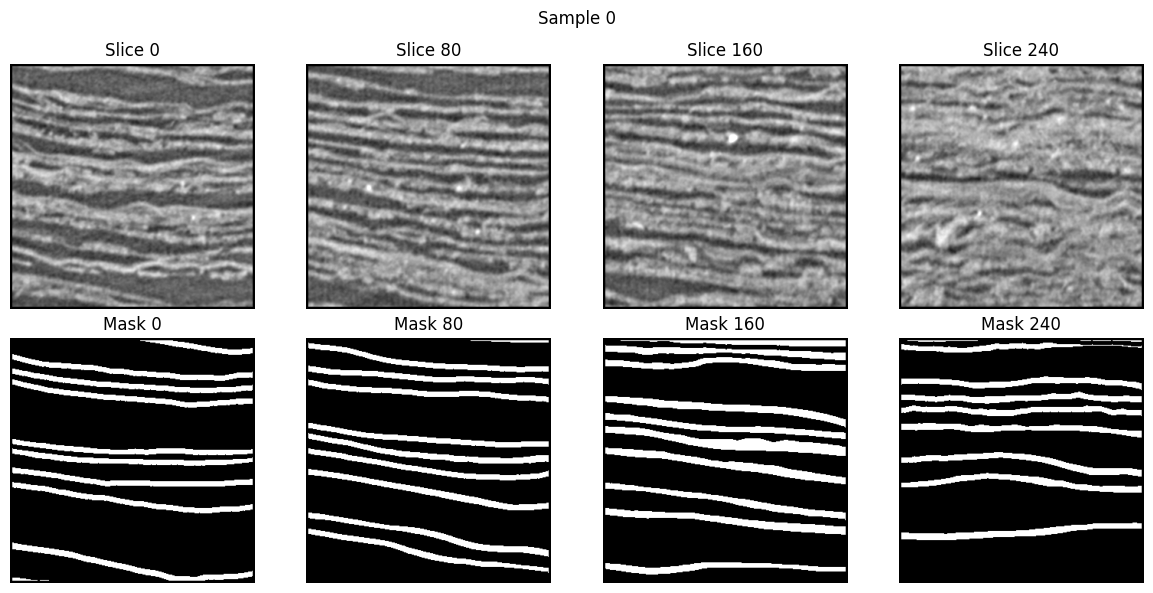

In [15]:
plot_sample(
    x, y, sample_idx=0, max_slices=4
)

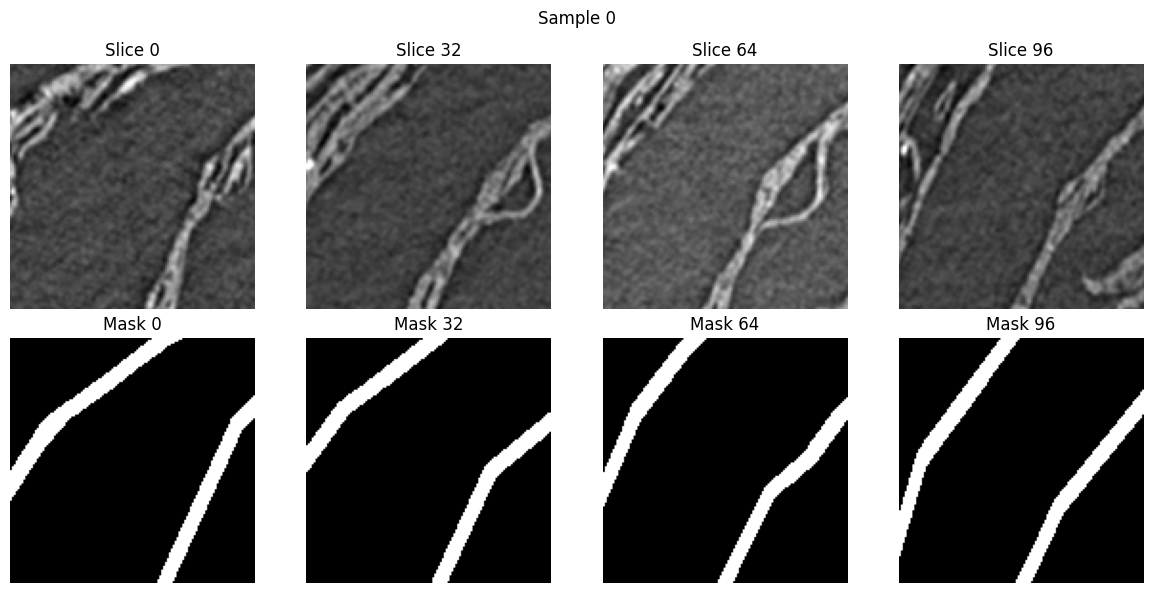

In [16]:
plot_sample(
    x_tf, y_tf, sample_idx=0, max_slices=4
)

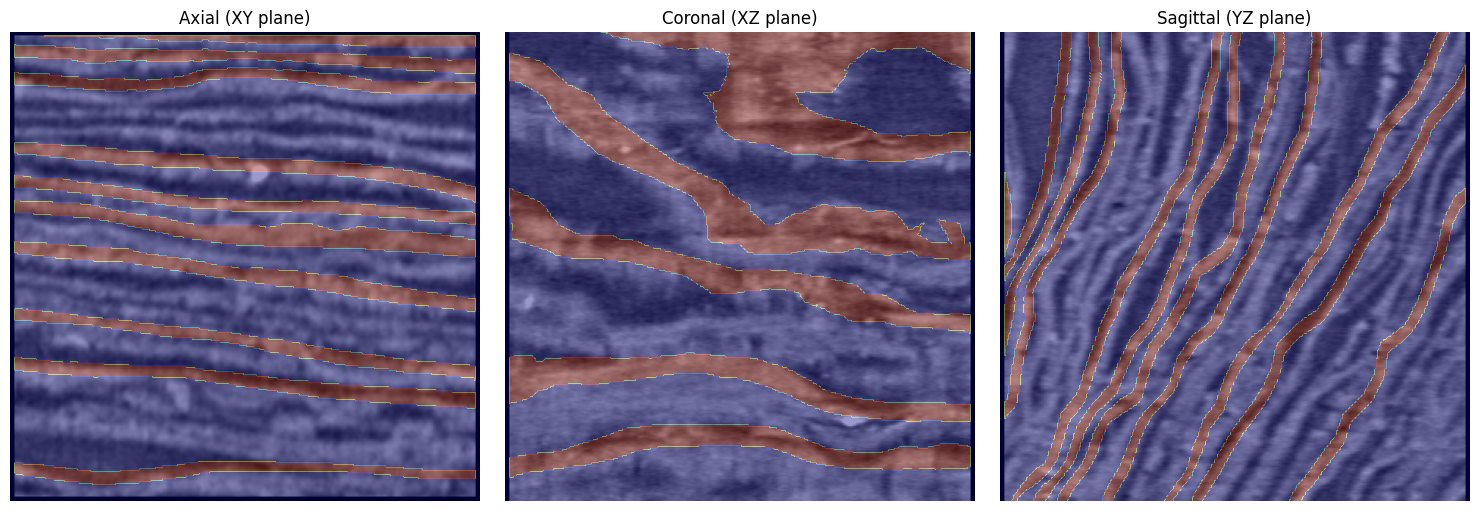

In [17]:
plot_planes(
    np.squeeze(x[0]), # picking one sample
    np.squeeze(y[0])  # picking one sample
)

## Model

In [18]:
import medicai
from medicai.models import SegFormer
from medicai.losses import BinaryDiceCELoss
from medicai.metrics import BinaryDiceMetric
from medicai.utils.inference import SlidingWindowInference

In [19]:
medicai.models.list_models()

                   Model Registry Catalog                    
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Segmentor        ┃ Backbone Family ┃ Variants             ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ • attention_unet │ convnext        │ • convnext_base      │
│ • deeplabv3plus  │                 │ • convnext_large     │
│ • unet           │                 │ • convnext_small     │
│ • unet_plus_plus │                 │ • convnext_tiny      │
│ • upernet        │                 │ • convnext_v2_atto   │
│                  │                 │ • convnext_v2_base   │
│                  │                 │ • convnext_v2_femto  │
│                  │                 │ • convnext_v2_huge   │
│                  │                 │ • convnext_v2_large  │
│                  │                 │ • convnext_v2_nano   │
│                  │                 │ • convnext_v2_pico   │
│                  │                 │ • convnext_v2_small  │
│                  │                 │ • convnext_v2_tiny   │
│                  │                 │ • convnext_xlarge    │
├──────────────────┼─────────────────┼──────────────────────┤
│ • attention_unet │ densenet        │ • densenet121        │
│ • deeplabv3plus  │                 │ • densenet169        │
│ • trans_unet     │                 │ • densenet201        │
│ • unet           │                 │ • densenet264        │
│ • unet_plus_plus │                 │                      │
│ • upernet        │                 │                      │
├──────────────────┼─────────────────┼──────────────────────┤
│ • attention_unet │ efficientnet    │ • efficientnet_b0    │
│ • deeplabv3plus  │                 │ • efficientnet_b1    │
│ • trans_unet     │                 │ • efficientnet_b2    │
│ • unet           │                 │ • efficientnet_b3    │
│ • unet_plus_plus │                 │ • efficientnet_b4    │
│ • upernet        │                 │ • efficientnet_b5    │
│                  │                 │ • efficientnet_b6    │
│                  │                 │ • efficientnet_b7    │
│                  │                 │ • efficientnet_b8    │
│                  │                 │ • efficientnet_l2    │
│                  │                 │ • efficientnet_v2_b0 │
│                  │                 │ • efficientnet_v2_b1 │
│                  │                 │ • efficientnet_v2_b2 │
│                  │                 │ • efficientnet_v2_b3 │
│                  │                 │ • efficientnet_v2_l  │
│                  │                 │ • efficientnet_v2_m  │
│                  │                 │ • efficientnet_v2_s  │
├──────────────────┼─────────────────┼──────────────────────┤
│ • segformer      │ mit             │ • mit_b0             │
│ • upernet        │                 │ • mit_b1             │
│                  │                 │ • mit_b2             │
│                  │                 │ • mit_b3             │
│                  │                 │ • mit_b4             │
│                  │                 │ • mit_b5             │
├──────────────────┼─────────────────┼──────────────────────┤
│ • attention_unet │ resnet          │ • resnet101          │
│ • deeplabv3plus  │                 │ • resnet101_v2       │
│ • trans_unet     │                 │ • resnet152          │
│ • unet           │                 │ • resnet152_v2       │
│ • unet_plus_plus │                 │ • resnet18           │
│ • upernet        │                 │ • resnet200_vd       │
│                  │                 │ • resnet34           │
│                  │                 │ • resnet50           │
│                  │                 │ • resnet50_v2        │
│                  │                 │ • resnet50_vd        │
│                  │                 │ • resnext101         │
│                  │                 │ • resnext50          │
├──────────────────┼─────────────────┼──────────────────────┤
│ • attention_unet │ senet      

<!DOCTYPE html>

In [20]:
num_classes = 1
model = SegFormer(
    input_shape=(128, 128, 128, 1),
    encoder_name='mit_b0',
    classifier_activation='sigmoid',
    num_classes=num_classes,
)
model.count_params() / 1e6

4.500513

## Training Pipeline

In [21]:
# define optomizer, loss
optim = keras.optimizers.AdamW(
    learning_rate=1e-4,
    weight_decay=1e-5,
)
loss_fn = BinaryDiceCELoss(
    from_logits=False, 
    num_classes=num_classes
)

# define sliding-window-inferencer for validation
swi = SlidingWindowInference(
    model,
    num_classes=num_classes,
    roi_size=(128, 128, 128),
    sw_batch_size=4,
    overlap=0.5,
)

In [22]:
def train_one_epoch(model, dataloader, metrics):
    loop = tqdm(dataloader, desc="Training", leave=False)
    
    for imgs, labels in loop:
        # forward pass
        outputs = model(imgs)
        loss = loss_fn(labels, outputs)

        # backward pass
        model.zero_grad()
        trainable_weights = [v for v in model.trainable_weights]

        # call torch.Tensor.backward() on the loss to compute gradients
        loss.backward()
        gradients = [v.value.grad for v in trainable_weights]

        # update weights
        with torch.no_grad():
            optim.apply(gradients, trainable_weights)

        # update training metric
        metrics.update_state(
            ops.convert_to_tensor(labels), 
            ops.convert_to_tensor(outputs)
        )
        
        # Update tqdm
        loss_score = ops.convert_to_numpy(loss)
        metrics_score = ops.convert_to_numpy(metrics.result())
        loop.set_postfix(
            loss=loss_score,
            dice=metrics_score,
        )

    return loss, metrics

In [23]:
def validate(model, dataloader, metrics):
    for sample in dataloader:
        x, y = sample
        output = swi(x)
        y = ops.convert_to_tensor(y)
        output = ops.convert_to_tensor(output)
        metrics.update_state(y, output)
    return metrics

In [24]:
def run_training(train_loader, val_loader, model, epochs=20):
    # metrics for train
    train_metrics = BinaryDiceMetric(
        from_logits=False, 
        num_classes=num_classes, 
        name='dice'
    )

    # metrics for validation
    val_metrics = BinaryDiceMetric(
        from_logits=False, 
        num_classes=num_classes, 
        name='val_dice'
    )
    
    # Initialize best validation dice score
    best_val_dice = 0.0

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        
        # Training
        loss, train_metrics = train_one_epoch(
            model, train_loader, train_metrics,
        )
        # display training logs at the end of epoch
        train_metrics_score = ops.convert_to_numpy(train_metrics.result())
        loss_score = ops.convert_to_numpy(loss)
        
        # reset training metrics at the end of each epoch
        train_metrics.reset_state()

        # Validation [at every 5 epoch]
        if (epoch + 1) % 5 == 0:
            val_metrics = validate(model, val_loader, val_metrics)
            val_metrics_score = ops.convert_to_numpy(
                val_metrics.result()
            )
            val_metrics.reset_state()
            print(
                f'Training - Loss: {loss_score:.4f}, Dice: {train_metrics_score:.4f}'
                f'\nValidation - Dice: {val_metrics_score:.4f}\n'
            )

            # Save best model weights
            if val_metrics_score > best_val_dice:
                best_val_dice = val_metrics_score
                model.save_weights('model.weights.h5')
                # torch.save(model.state_dict(), 'model.pth') # OK too.
                print(
                    f'Dice score improved: {best_val_dice}. Model saved.'
                )
        else:
            print(
                f'Training - Loss: {loss_score:.4f}, Dice: {train_metrics_score:.4f}\n'
            )

In [25]:
run_training(
    train_ds, val_ds, model, epochs=20
)

Epoch 1/20


Training - Loss: 1.2450, Dice: 0.1951

Epoch 2/20


Training - Loss: 1.2612, Dice: 0.1973

Epoch 3/20


Training - Loss: 1.2582, Dice: 0.2271

Epoch 4/20


Training - Loss: 1.2623, Dice: 0.2255

Epoch 5/20


Total patch 64: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]


Training - Loss: 1.0916, Dice: 0.2128
Validation - Dice: 0.2046

Dice score improved: 0.20460043847560883. Model saved.
Epoch 6/20


Training - Loss: 1.2096, Dice: 0.2524

Epoch 7/20


Training - Loss: 1.1807, Dice: 0.2557

Epoch 8/20


Training - Loss: 0.9702, Dice: 0.2607

Epoch 9/20


Training - Loss: 1.1828, Dice: 0.2409

Epoch 10/20


Total patch 64: 100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


Training - Loss: 1.2952, Dice: 0.2146
Validation - Dice: 0.2007

Epoch 11/20


Training - Loss: 1.2632, Dice: 0.2381

Epoch 12/20


Training - Loss: 1.2218, Dice: 0.2683

Epoch 13/20


Training - Loss: 1.1920, Dice: 0.2672

Epoch 14/20


Training - Loss: 1.1537, Dice: 0.2396

Epoch 15/20


Total patch 64: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]


Training - Loss: 1.4445, Dice: 0.2651
Validation - Dice: 0.2582

Dice score improved: 0.25822144746780396. Model saved.
Epoch 16/20


Training - Loss: 1.2119, Dice: 0.2622

Epoch 17/20


Training - Loss: 1.3234, Dice: 0.2681

Epoch 18/20


Training - Loss: 0.9894, Dice: 0.2742

Epoch 19/20


Training - Loss: 1.1004, Dice: 0.2683

Epoch 20/20


Total patch 64: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


Training - Loss: 1.3613, Dice: 0.2762
Validation - Dice: 0.2484



In [26]:
x, y = next(iter(val_ds))
x.shape, y.shape

(TensorShape([1, 320, 320, 320, 1]), TensorShape([1, 320, 320, 320, 1]))

In [27]:
y_pred = swi(x)
y_pred.shape

Total patch 64: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


(1, 320, 320, 320, 1)

In [28]:
segment = (y_pred > 0.35).astype(np.uint8)
segment.shape, np.unique(segment)

((1, 320, 320, 320, 1), array([0, 1], dtype=uint8))

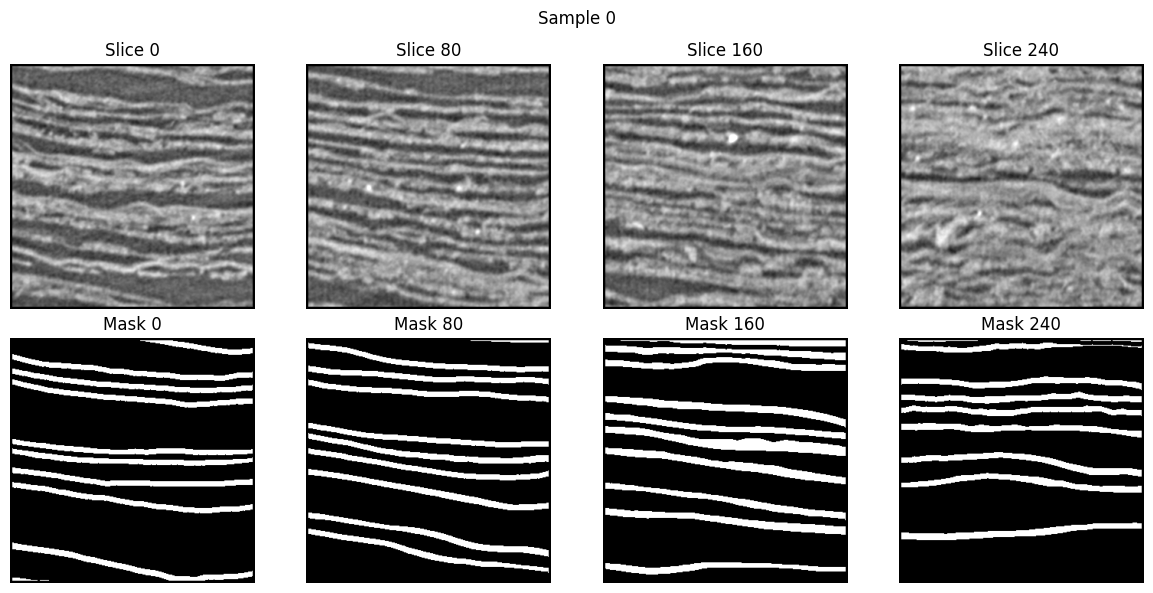

In [29]:
plot_sample(
    x, y, sample_idx=0, max_slices=4
)

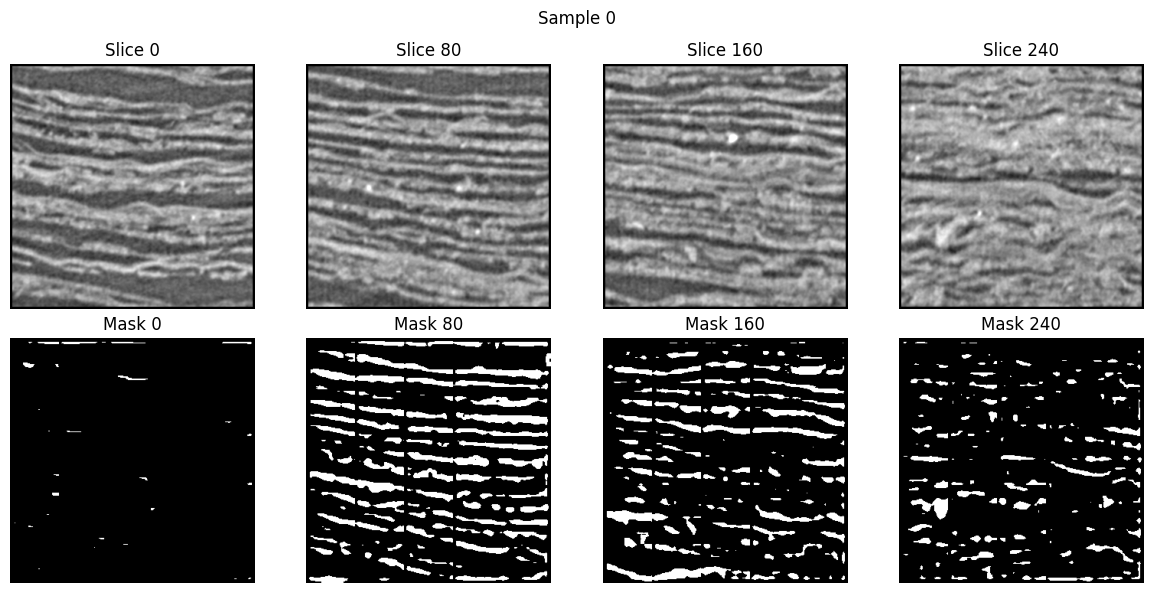

In [30]:
plot_sample(
    x, segment, sample_idx=0, max_slices=4
)